# whiten particle stack

In [139]:
import numpy as np
import jax
import cryojax.simulator as cs
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [79]:
n_pix = 64
shape = (n_pix,n_pix)
# image = np.arange(n_pix**2).reshape((n_pix,n_pix)).astype(np.float32)
noise = np.random.normal(np.zeros(shape), 1)
# image += noise

coords = make_coordinates(shape)


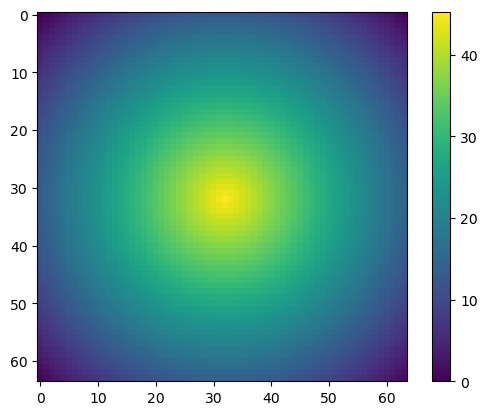

In [89]:
rad = np.hypot(coords[:,:,0], coords[:,:,1])
diffusing_circle = rad.max() - rad
plt.imshow(diffusing_circle)
plt.colorbar()

In [132]:
from cryojax.utils import (
    rfftn,
    fftn,
    ifftn,
    make_coordinates,
    make_frequencies,
    powerspectrum,
)

freq = make_frequencies((n_pix, n_pix), half_space=False)

In [92]:
whitening_filter = cs.filter.WhiteningFilter(freq, diffusing_circle)

In [93]:
whitening_filter.filter.shape

(64, 64)

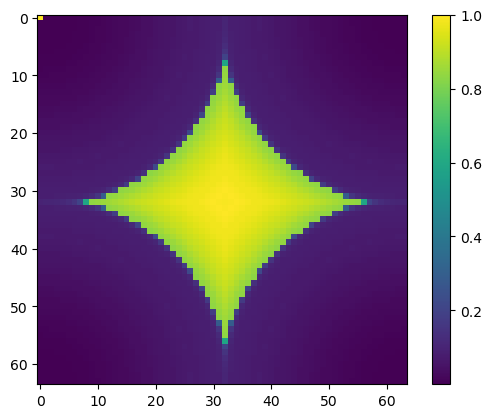

In [94]:
plt.imshow(whitening_filter.filter)
plt.colorbar()

In [97]:
whitened_f = whitening_filter(fftn(diffusing_circle))
whitened_r = ifftn(whitened_f)

In [112]:
whitened_r

Array([[20.722902+4.97358599e-10j, 20.747822-2.96089819e-08j,
        20.743608+5.97904588e-08j, ..., 20.74265 -1.34725173e-08j,
        20.743608+6.15958271e-08j, 20.747822-3.33957857e-08j],
       [20.747824+1.00148974e-08j, 20.773623-8.87976626e-09j,
        20.769608-9.18724652e-10j, ..., 20.770147-4.33432703e-08j,
        20.769608+3.19618465e-09j, 20.773623-1.33552405e-08j],
       [20.743607+5.10889677e-08j, 20.769606-2.58687294e-08j,
        20.765089+1.01034587e-07j, ..., 20.76582 -5.23526538e-08j,
        20.765089+1.04978938e-07j, 20.769606-2.95865359e-08j],
       ...,
       [20.742655+1.23974004e-08j, 20.770147-4.38061747e-08j,
        20.765821+8.01767897e-09j, ..., 20.76525 -1.73168743e-07j,
        20.765821+1.40951784e-08j, 20.770147-4.99745170e-08j],
       [20.743607+3.00885326e-08j, 20.769606-1.67463590e-08j,
        20.765089+7.95273962e-08j, ..., 20.76582 +4.81103974e-08j,
        20.765089+8.55536513e-08j, 20.769606-2.22950511e-08j],
       [20.747824-2.37754634

In [113]:
np.linalg.norm(whitened_r.real), np.linalg.norm(whitened_r.imag)

(1328.8983, 7.456011e-06)

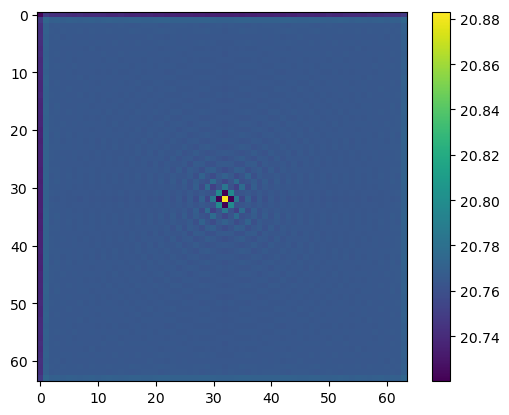

In [114]:
plt.imshow(whitened_r.real)
plt.colorbar()

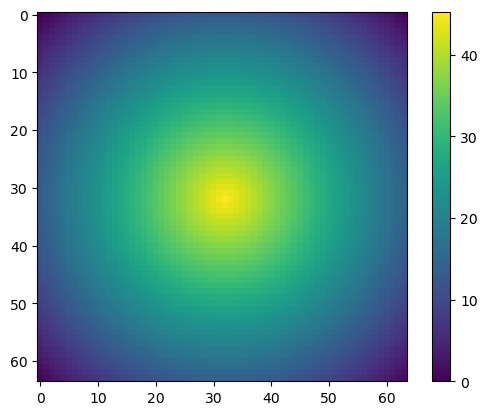

In [115]:
plt.imshow(diffusing_circle.real)
plt.colorbar()

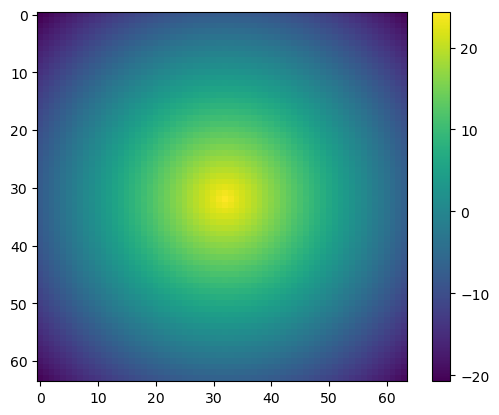

In [116]:
plt.imshow(diffusing_circle - whitened_r.real)
plt.colorbar()

# low pass filter

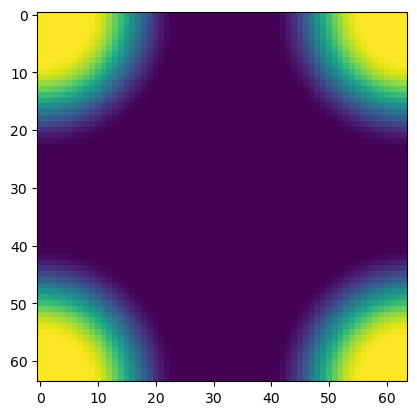

In [156]:
low_pass_filter = cs.filter.LowpassFilter(freq,cutoff=0.75, rolloff=0.5)
plt.imshow(low_pass_filter.filter)


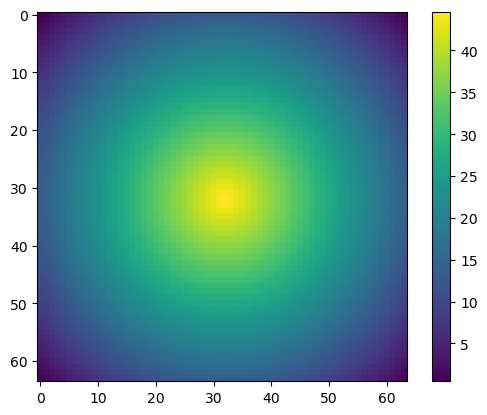

In [163]:
diffusing_circle_lpf_f = low_pass_filter(fftn(diffusing_circle))
diffusing_circle_lpf_r = ifftn(diffusing_circle_lpf_f).real
plt.imshow(diffusing_circle_lpf_r)
plt.colorbar()

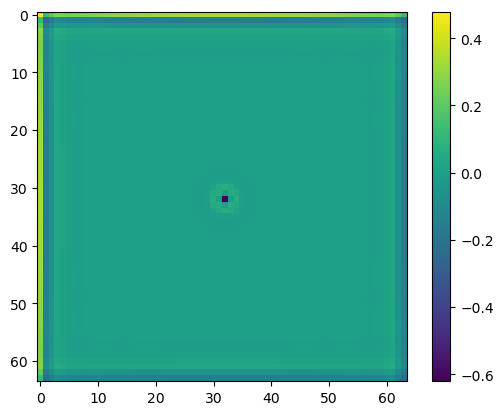

In [162]:
plt.imshow(diffusing_circle_lpf_r - diffusing_circle)
plt.colorbar()

# double filter

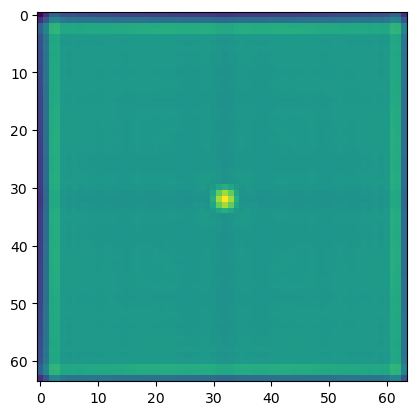

In [168]:
double_filter = cs.filter._ProductFilter(whitening_filter,low_pass_filter)
whitened_f = double_filter(fftn(diffusing_circle))
whitened_r = ifftn(whitened_f)

plt.imshow(whitened_r.real)

## manual whitening

In [125]:
micrograph = diffusing_circle
grid_spacing = 1
freqs = make_frequencies(shape)


In [126]:
micrograph_frequency_grid = make_frequencies(
    micrograph.shape, grid_spacing
)

fourier_micrograph = rfftn(micrograph)
radial_frequency_grid = jnp.linalg.norm(micrograph_frequency_grid, axis=-1)

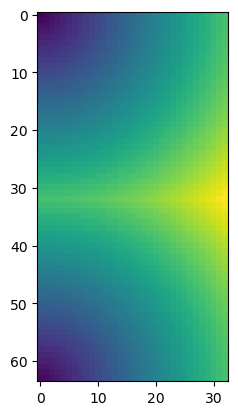

In [127]:
plt.imshow(radial_frequency_grid)

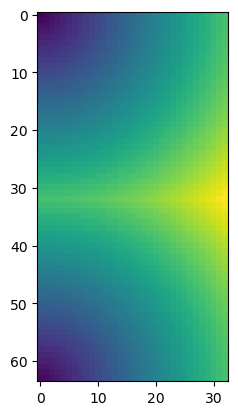

In [131]:
interpolating_radial_frequency_grid = jnp.linalg.norm(freqs, axis=-1)
plt.imshow(interpolating_radial_frequency_grid)

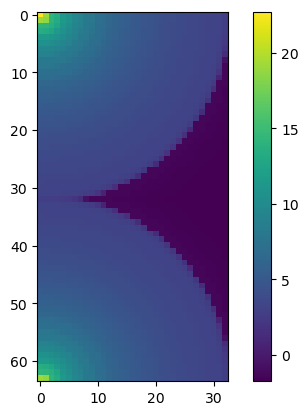

In [145]:
# Compute power spectrum
spectrum, _ = powerspectrum(
    fourier_micrograph,
    radial_frequency_grid,
    k_max=jnp.sqrt(2.0) / 2.0,
    interpolating_radial_frequency_grid=interpolating_radial_frequency_grid,
)
plt.imshow(np.log(spectrum))
plt.colorbar()

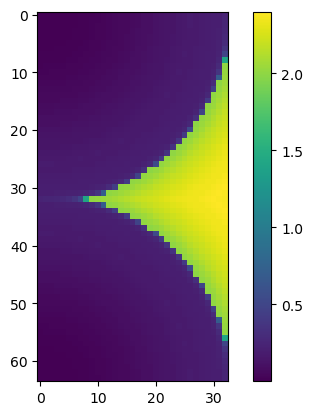

In [148]:
filter = jax.lax.rsqrt(spectrum)
plt.imshow(filter)
plt.colorbar()

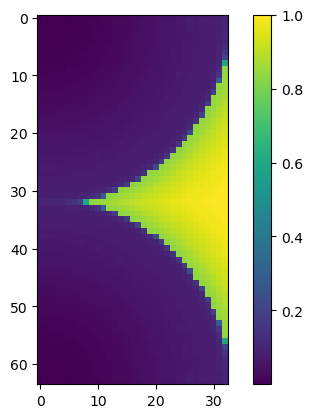

In [147]:
maximum = jnp.max(jnp.delete(filter, jnp.asarray((0, 0), dtype=int)))
filter /= maximum
plt.imshow(filter)
plt.colorbar()

# debug whitening
* power in frequency shell

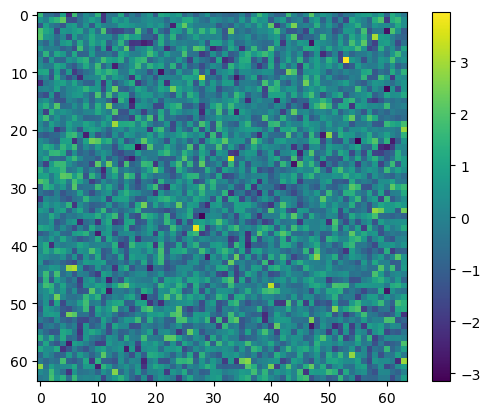

In [237]:
np.random.seed(1)
micrograph = np.random.normal(np.zeros(shape), 1)
plt.imshow(micrograph)
plt.colorbar()

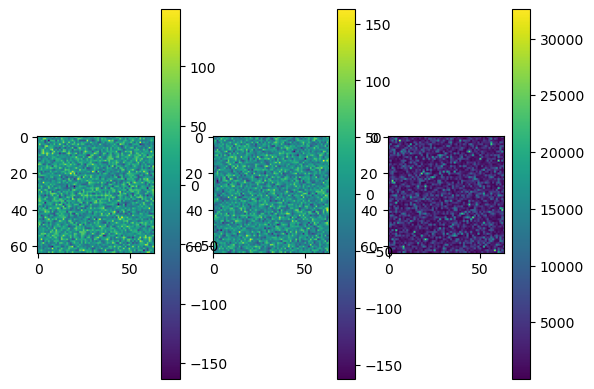

In [251]:
fourier_micrograph = np.fft.fftshift(np.fft.fftn(micrograph))

fig, axes = plt.subplots(1,3)
ax0 = axes[0].imshow(fourier_micrograph.real)
fig.colorbar(ax0,ax=axes[0])

ax1 = axes[1].imshow(fourier_micrograph.imag)
fig.colorbar(ax1,ax=axes[1])

power = (fourier_micrograph * jnp.conjugate(fourier_micrograph)).real

ax1 = axes[2].imshow(power)
fig.colorbar(ax1,ax=axes[2])


In [229]:
micrograph_frequency_grid = np.fft.fftshift(make_frequencies(shape, grid_spacing=1, half_space=False))
radial_frequency_grid = jnp.linalg.norm(micrograph_frequency_grid, axis=-1)
interpolating_radial_frequency_grid = jnp.linalg.norm(micrograph_frequency_grid, axis=-1)


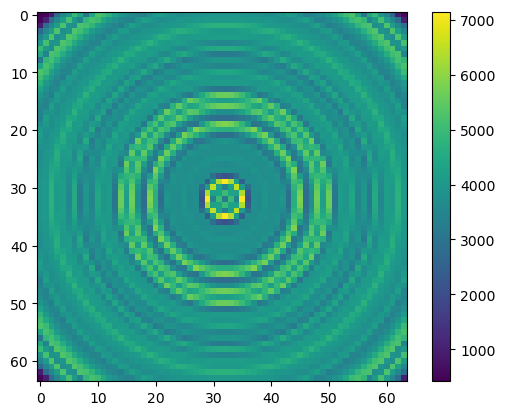

In [250]:
spectrum, _ = powerspectrum(
    fourier_micrograph,
    radial_frequency_grid,
    k_max=jnp.sqrt(2.0) / 2.0,
    interpolating_radial_frequency_grid=interpolating_radial_frequency_grid,
)
plt.imshow(spectrum)
plt.colorbar()

In [231]:
filter = jax.lax.rsqrt(spectrum)

Array(0.01597288, dtype=float32)

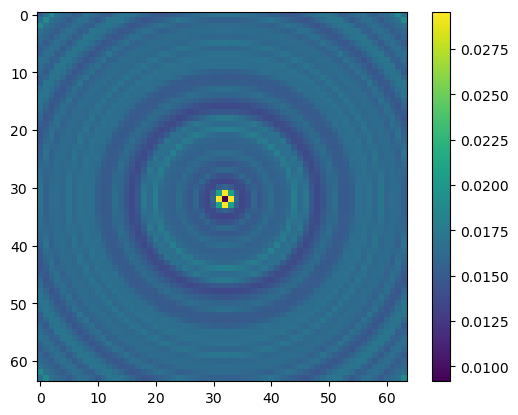

In [232]:
plt.imshow(filter)
plt.colorbar()
filter.mean()

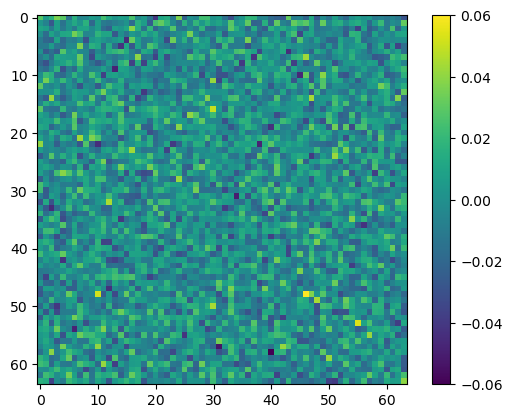

In [234]:
whitened_r = np.fft.ifftn(np.fft.ifftshift(fourier_micrograph * filter)).real
plt.imshow(whitened_r.real)
plt.colorbar()

# debug powerspectrum

In [256]:
from cryojax.utils import radial_average

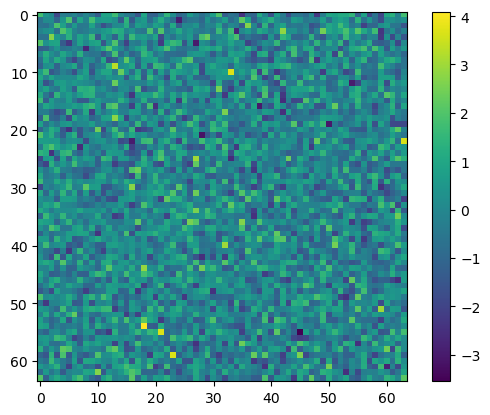

In [283]:
seed=3
np.random.seed(seed)
image_r = np.random.normal(np.zeros(shape), 1)
plt.imshow(image_r)
plt.colorbar()

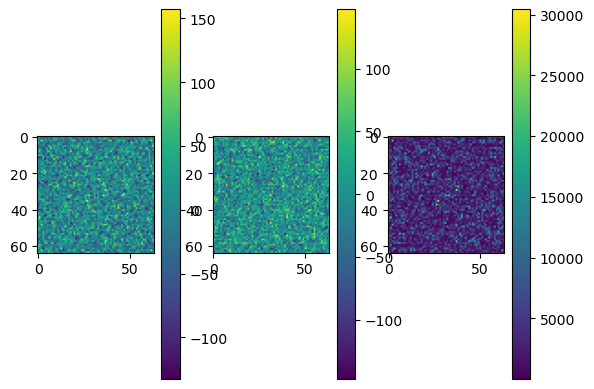

In [284]:
image_f = np.fft.fftshift(np.fft.fftn(image_r))

fig, axes = plt.subplots(1,3)
ax0 = axes[0].imshow(image_f.real)
fig.colorbar(ax0,ax=axes[0])

ax1 = axes[1].imshow(image_f.imag)
fig.colorbar(ax1,ax=axes[1])

power = (image_f * jnp.conjugate(image_f)).real

ax1 = axes[2].imshow(power)
fig.colorbar(ax1,ax=axes[2])


In [285]:
k_min, k_max = 0, 0.5
pixel_size=1
k_step = 1.0 / (pixel_size * max(*power.shape))
bins = jnp.arange(k_min, k_max, k_step)
bins

Array([0.      , 0.015625, 0.03125 , 0.046875, 0.0625  , 0.078125,
       0.09375 , 0.109375, 0.125   , 0.140625, 0.15625 , 0.171875,
       0.1875  , 0.203125, 0.21875 , 0.234375, 0.25    , 0.265625,
       0.28125 , 0.296875, 0.3125  , 0.328125, 0.34375 , 0.359375,
       0.375   , 0.390625, 0.40625 , 0.421875, 0.4375  , 0.453125,
       0.46875 , 0.484375], dtype=float32)

Text(0.5, 1.0, 'radially averaged power of random gaussian noise \n random_seed=3')

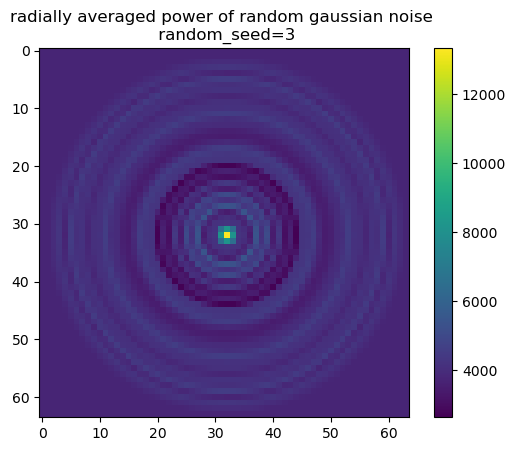

In [286]:
spectrum = radial_average(
    power, radial_frequency_grid, bins, interpolating_radial_frequency_grid
)

plt.imshow(spectrum)
plt.colorbar()
plt.title(f'radially averaged power of random gaussian noise \n random_seed={seed}')

In [303]:
n_samples=1000
spectra = np.empty((n_samples,*shape))
for idx, seed in enumerate(range(n_samples)):
    np.random.seed(seed)
    image_r = np.random.normal(np.zeros(shape), 1)
    image_f = np.fft.fftshift(np.fft.fftn(image_r))

    power = (image_f * jnp.conjugate(image_f)).real
    spectrum = radial_average(
        power, radial_frequency_grid, bins, interpolating_radial_frequency_grid
    )
    spectra[idx] = spectrum


Text(0.5, 1.0, 'radially averaged power of random gaussian noise \n random_seed=3')

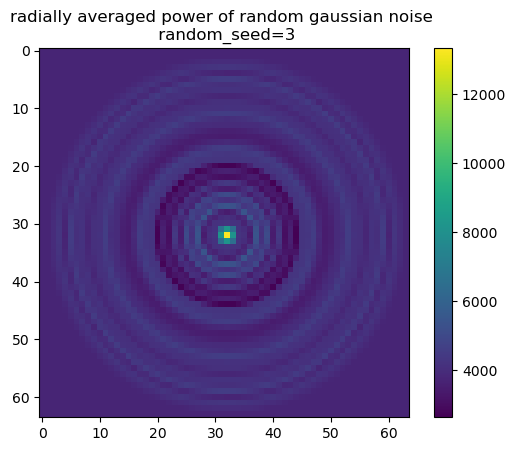

In [301]:
idx=3
plt.imshow(spectra[idx])
plt.colorbar()
plt.title(f'radially averaged power of random gaussian noise \n random_seed={idx}')

Text(0.5, 1.0, 'Expectation of radially averaged power of random gaussian noise \n n_samples=1000')

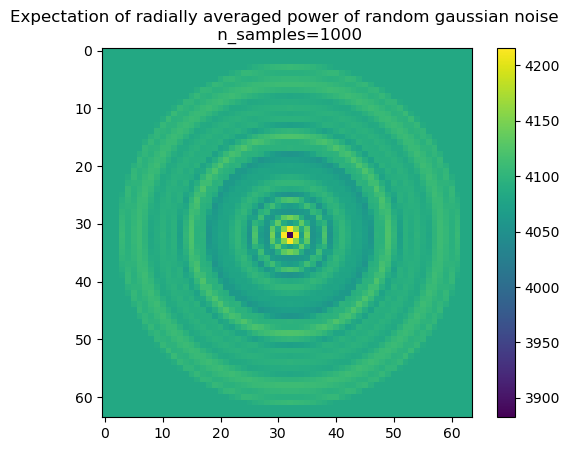

In [304]:
plt.imshow(spectra.mean(0))
plt.colorbar()
plt.title(f'Expectation of radially averaged power of random gaussian noise \n n_samples={n_samples}')

Text(0.5, 1.0, 'Std of radially averaged power of random gaussian noise \n n_samples=1000')

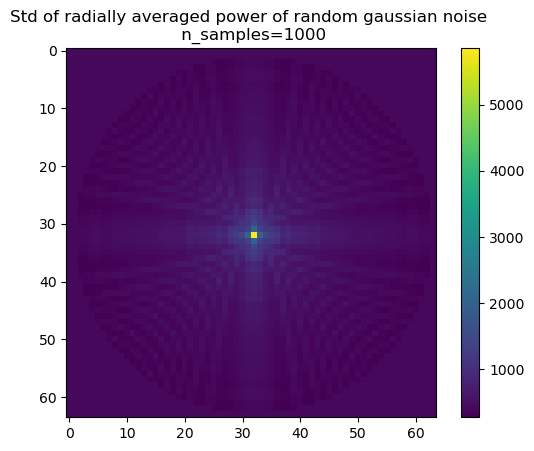

In [305]:
plt.imshow(spectra.std(0))
plt.colorbar()
plt.title(f'Std of radially averaged power of random gaussian noise \n n_samples={n_samples}')